In [54]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt

# data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

In [3]:
train = pd.read_csv(r'/kaggle/input/crime-multiclass-classification/train.csv')
test = pd.read_csv(r'/kaggle/input/crime-multiclass-classification/test.csv')
sample = pd.read_csv(r'/kaggle/input/crime-multiclass-classification/sampleSubmission.csv')

In [4]:
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [5]:
test.head(2)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432


In [6]:
sample.head(4)

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Data Cleaning and Exploration

### Train Set

In [7]:
train.info() #-there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [8]:
train.describe(include = 'all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878049,878049,878049,878049,878049,878049,878049,878049.000000,878049.000000
unique,389257,39,879,7,10,17,23228,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174900,60022,133734,157182,526790,26533,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422616,37.771020
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030354,0.456893
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.416420,37.775421
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.406959,37.784369


In [9]:
train['Dates'].head() #-we would perform feature engineering on this to separate it year, month, etc

0    2015-05-13 23:53:00
1    2015-05-13 23:53:00
2    2015-05-13 23:33:00
3    2015-05-13 23:30:00
4    2015-05-13 23:30:00
Name: Dates, dtype: object

In [10]:
train['PdDistrict'].value_counts()

PdDistrict
SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: count, dtype: int64

In [11]:
# pdgroup = train.groupby('pdDistrict')

In [12]:
train['Resolution'].value_counts()

Resolution
NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: count, dtype: int64

In [13]:
print(train['Category'].nunique())
train['Category'].value_counts() #- target column that will be used for multilabel classification

39


Category
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQ

#### Data Type Conversion and Feature Engineering on Train and Test Set

In [14]:
#Convert Dates column to datetime format
#Train set
train['Dates'] = pd.to_datetime(train['Dates'])

#Test set
test['Dates'] = pd.to_datetime(test['Dates'])

##### Feature Engineering

In [15]:
#Extracting features from Date
#Train set
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['DayOfMonth'] = train['Dates'].dt.day
train['Hour'] = train['Dates'].dt.hour
train['Minute'] = train['Dates'].dt.minute
train['Quarter'] = train['Dates'].dt.quarter

#Test set
test['Year'] = train['Dates'].dt.year
test['Month'] = test['Dates'].dt.month
test['DayofMonth'] = test['Dates'].dt.day
test['Hour'] = test['Dates'].dt.hour
test['Minute'] = test['Dates'].dt.minute
test['Quarter'] = test['Dates'].dt.quarter

In [16]:
test.dropna(inplace = True)

In [17]:
np.unique(test['Year'])

array([2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015.])

In [18]:
print(train.shape)
print(test.shape)

(878049, 15)
(878049, 13)


In [19]:
# Create KMeans clusters based on geographical coordinates 
num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(train[['X', 'Y']]) 

train['Cluster'] = kmeans.predict(train[['X', 'Y']]) 
test['Cluster'] = kmeans.predict(test[['X', 'Y']]) 

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

In [20]:
# Feature Renaming for easy understanding
train.rename(columns={'X': 'Longitude', 'Y': 'Latitude'}, inplace=True)
test.rename(columns={'X': 'Longitude', 'Y': 'Latitude'}, inplace=True)

### EDA

#### BAsic Visualizations to get a basic understanding of the data

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


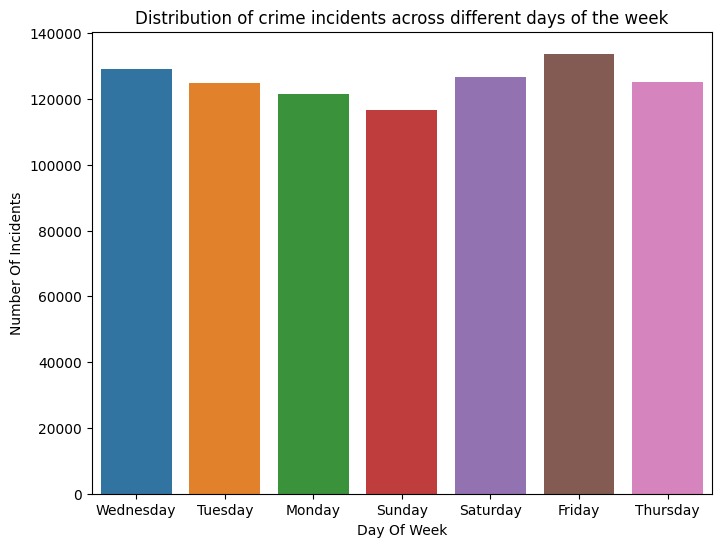

In [21]:
# What is the distribution of crime incidents across different days of the week?

plt.figure(figsize=(8,6))
sns.countplot(x='DayOfWeek', data=train)
plt.xlabel('Day Of Week')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different days of the week')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


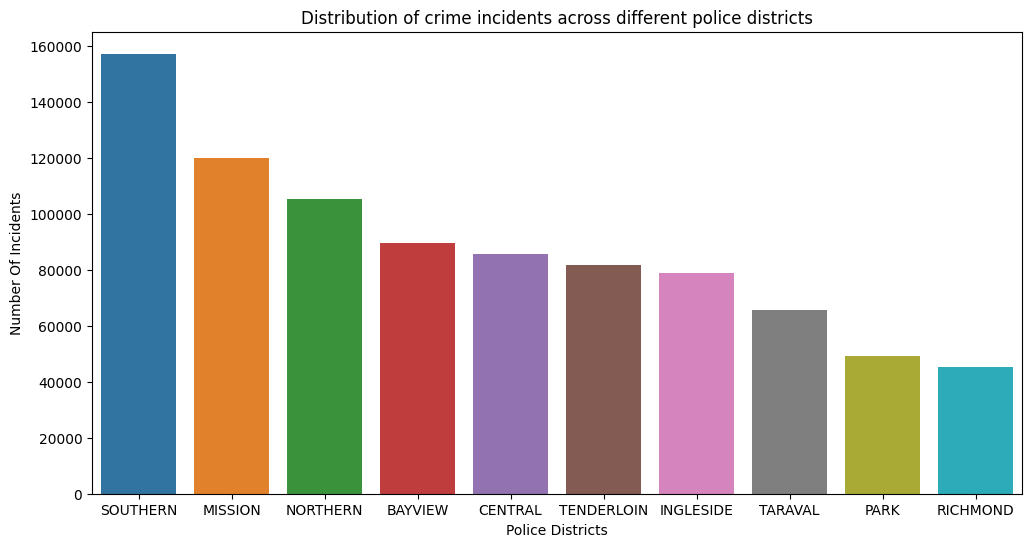

In [22]:
# How does crime rate vary by police district?

plt.figure(figsize=(12,6))
sns.countplot(x='PdDistrict', data = train, order = train['PdDistrict'].value_counts().index)
plt.xlabel('Police Districts')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different police districts')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


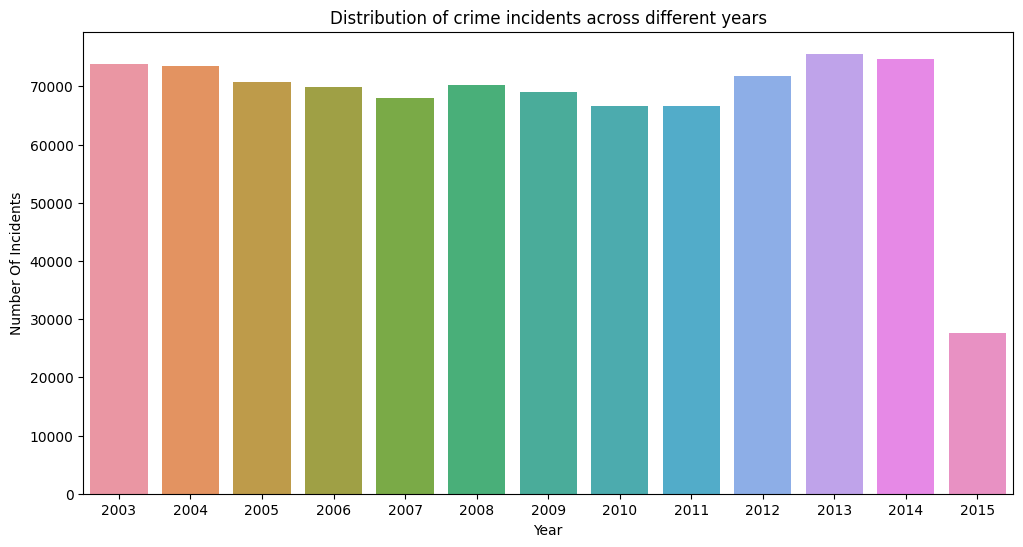

In [23]:
# What is the trend of crime incidents over the year?

plt.figure(figsize=(12,6))
sns.countplot(x='Year', data = train)
plt.xlabel('Year')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different years')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


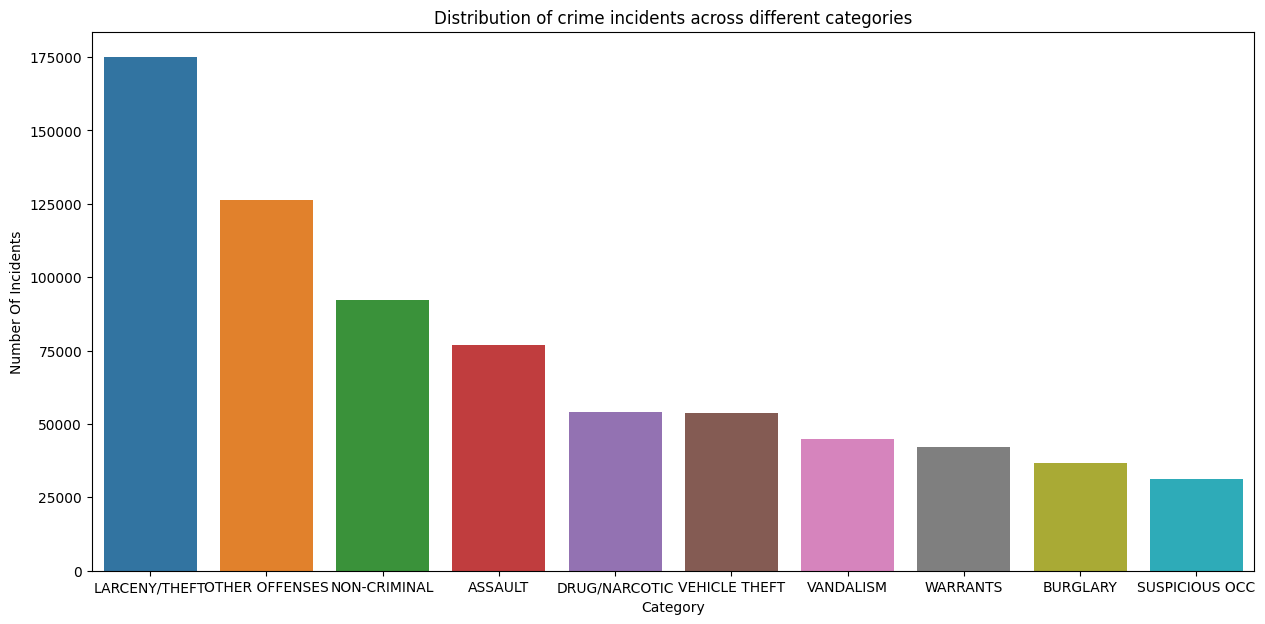

In [24]:
#How does the distribution of incidents vary by crime category

plt.figure(figsize=(15,7))
sns.countplot(x='Category', data = train, order = train['Category'].value_counts().iloc[:10].index)
plt.xlabel('Category')
plt.ylabel('Number Of Incidents')
plt.title('Distribution of crime incidents across different categories')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


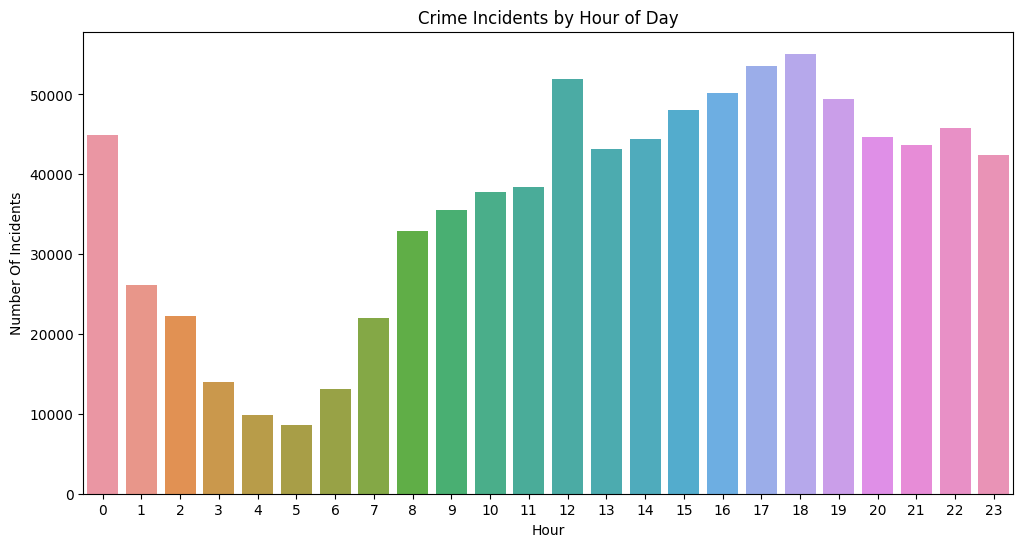

In [25]:
# Are there any patterns in crime incidents based on hours of the day?

plt.figure(figsize=(12,6))
sns.countplot(x='Hour',data = train)
plt.xlabel('Hour')
plt.ylabel('Number Of Incidents')
plt.title('Crime Incidents by Hour of Day')
plt.show()

#### Geospatial Visualtizations

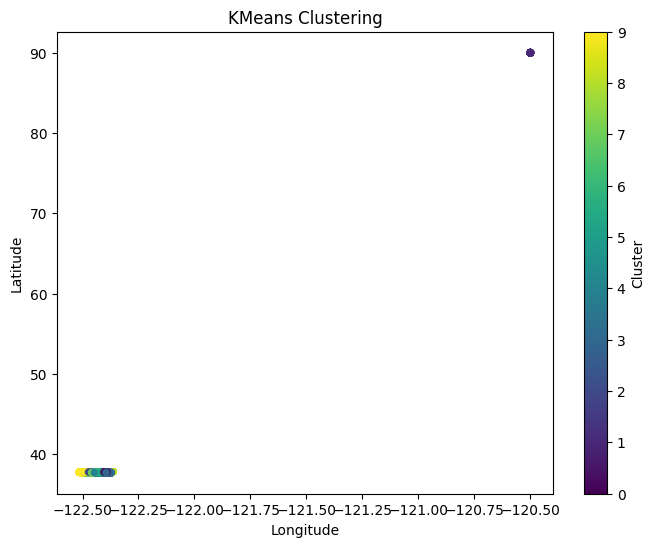

In [26]:
# Scatter plot to show different clusters 

plt.figure(figsize=(8, 6))
plt.scatter(train['Longitude'], train['Latitude'], c=train['Cluster'], cmap='viridis', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering')
plt.colorbar(label='Cluster')
plt.show()


# Data preprocessing

In [27]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,30,2,6


In [28]:
# converting all the input into lower case
def lower(df, features):
    for feature in features:
        df[feature] = df[feature].apply(lambda x: x.lower())

In [29]:
lower(train, ['Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address'])
lower(train, ['Category'])
lower(test, ['DayOfWeek', 'PdDistrict', 'Address'])
train.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,warrants,warrant arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",vanness av / greenwich st,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,northern,none,1500 block of lombard st,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,park,none,100 block of broderick st,-122.438738,37.771541,2015,5,13,23,30,2,6


In [30]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,Longitude,Latitude,Year,Month,DayofMonth,Hour,Minute,Quarter,Cluster
0,0,2015-05-10 23:59:00,sunday,bayview,2000 block of thomas av,-122.399588,37.735051,2015.0,5,10,23,59,2,3
1,1,2015-05-10 23:51:00,sunday,bayview,3rd st / revere av,-122.391523,37.732432,2015.0,5,10,23,51,2,3
2,2,2015-05-10 23:50:00,sunday,northern,2000 block of gough st,-122.426002,37.792212,2015.0,5,10,23,50,2,6
3,3,2015-05-10 23:45:00,sunday,ingleside,4700 block of mission st,-122.437394,37.721412,2015.0,5,10,23,45,2,4
4,4,2015-05-10 23:45:00,sunday,ingleside,4700 block of mission st,-122.437394,37.721412,2015.0,5,10,23,45,2,4


In [31]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,warrants,warrant arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,other offenses,traffic violation arrest,wednesday,northern,"arrest, booked",vanness av / greenwich st,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,northern,none,1500 block of lombard st,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,larceny/theft,grand theft from locked auto,wednesday,park,none,100 block of broderick st,-122.438738,37.771541,2015,5,13,23,30,2,6


In [32]:
test_id = test['Id']

In [33]:
le = LabelEncoder()
for feature in ['DayOfWeek', 'PdDistrict', 'Address', 'Category']:
    train[feature] = le.fit_transform(train[feature])

train

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Longitude,Latitude,Year,Month,DayOfMonth,Hour,Minute,Quarter,Cluster
0,2015-05-13 23:53:00,37,warrant arrest,6,4,"arrest, booked",19790,-122.425892,37.774599,2015,5,13,23,53,2,6
1,2015-05-13 23:53:00,21,traffic violation arrest,6,4,"arrest, booked",19790,-122.425892,37.774599,2015,5,13,23,53,2,6
2,2015-05-13 23:33:00,21,traffic violation arrest,6,4,"arrest, booked",22697,-122.424363,37.800414,2015,5,13,23,33,2,6
3,2015-05-13 23:30:00,16,grand theft from locked auto,6,4,none,4266,-122.426995,37.800873,2015,5,13,23,30,2,6
4,2015-05-13 23:30:00,16,grand theft from locked auto,6,5,none,1843,-122.438738,37.771541,2015,5,13,23,30,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,25,robbery on the street with a gun,1,8,none,15816,-122.459033,37.714056,2003,1,6,0,15,1,7
878045,2003-01-06 00:01:00,16,grand theft from locked auto,1,2,none,11491,-122.447364,37.731948,2003,1,6,0,1,1,4
878046,2003-01-06 00:01:00,16,grand theft from locked auto,1,7,none,11315,-122.403390,37.780266,2003,1,6,0,1,1,0
878047,2003-01-06 00:01:00,35,"malicious mischief, vandalism of vehicles",1,7,none,22308,-122.390531,37.780607,2003,1,6,0,1,1,0


In [34]:
X = train.drop(['Dates', 'Cluster', 'Descript', 'Resolution', 'Category'], axis = 1)
y = train.Category
test.drop(['Dates', 'Cluster'], axis = 1, inplace = True)

In [35]:
for feature in ['DayOfWeek', 'PdDistrict', 'Address']:
    test[feature] = le.fit_transform(test[feature]) 

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [36]:
test

,Id,DayOfWeek,PdDistrict,Address,Longitude,Latitude,Year,Month,DayofMonth,Hour,Minute,Quarter
0,0,3,0,6403,-122.399588,37.735051,2015.0,5,10,23,59,2
1,1,3,0,9739,-122.391523,37.732432,2015.0,5,10,23,51,2
2,2,3,4,6332,-122.426002,37.792212,2015.0,5,10,23,50,2
3,3,3,2,10627,-122.437394,37.721412,2015.0,5,10,23,45,2
4,4,3,2,10627,-122.437394,37.721412,2015.0,5,10,23,45,2
...,...,...,...,...,...,...,...,...,...,...,...,...
878044,878044,6,4,14582,-122.436275,37.800813,2003.0,1,29,21,0,1
878045,878045,6,4,7219,-122.434667,37.788745,2003.0,1,29,21,0,1
878046,878046,6,4,14582,-122.436275,37.800813,2003.0,1,29,21,0,1
878047,878047,6,1,21227,-122.401857,37.796626,2003.0,1,29,21,0,1


In [37]:
np.unique(test['Year'])

array([2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015.])

In [38]:
test.drop('Id', axis = 1, inplace = True)

In [39]:
X_copy, test_copy = X.copy(), test.copy()

# Model building

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 4, stratify=y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [41]:
y_train

462077     8
460991     7
156688    19
56233     32
508301    21
          ..
470417    28
699384    36
533945    12
729386    23
44913      1
Name: Category, Length: 702439, dtype: int64

In [42]:
cat_model = CatBoostClassifier(learning_rate=0.2, iterations=1500, task_type='GPU', depth=10)

In [43]:
cat_model.fit(X_train, y_train)

0:	learn: 2.9992391	total: 376ms	remaining: 9m 24s
1:	learn: 2.8133984	total: 593ms	remaining: 7m 24s
2:	learn: 2.7022740	total: 806ms	remaining: 6m 42s
3:	learn: 2.6228192	total: 1.01s	remaining: 6m 16s
4:	learn: 2.5681363	total: 1.22s	remaining: 6m 3s
5:	learn: 2.5255987	total: 1.42s	remaining: 5m 54s
6:	learn: 2.4932380	total: 1.59s	remaining: 5m 39s
7:	learn: 2.4663844	total: 1.76s	remaining: 5m 29s
8:	learn: 2.4457515	total: 1.98s	remaining: 5m 28s
9:	learn: 2.4253309	total: 2.17s	remaining: 5m 23s
10:	learn: 2.4089159	total: 2.35s	remaining: 5m 18s
11:	learn: 2.3955952	total: 2.57s	remaining: 5m 18s
12:	learn: 2.3866254	total: 2.78s	remaining: 5m 17s
13:	learn: 2.3777180	total: 3s	remaining: 5m 18s
14:	learn: 2.3689502	total: 3.21s	remaining: 5m 17s
15:	learn: 2.3623962	total: 3.42s	remaining: 5m 17s
16:	learn: 2.3564808	total: 3.6s	remaining: 5m 14s
17:	learn: 2.3497720	total: 3.78s	remaining: 5m 11s
18:	learn: 2.3445525	total: 4s	remaining: 5m 11s
19:	learn: 2.3393764	total: 4.

In [49]:
pred_pro = cat_model.predict_proba(X_test)
pred = cat_model.predict(X_test)

In [57]:
pred

array([[36],
       [36],
       [16],
       ...,
       [ 7],
       [16],
       [16]])

In [50]:
print(log_loss(y_test, pred_pro))

2.4496653917866866


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

<Axes: >

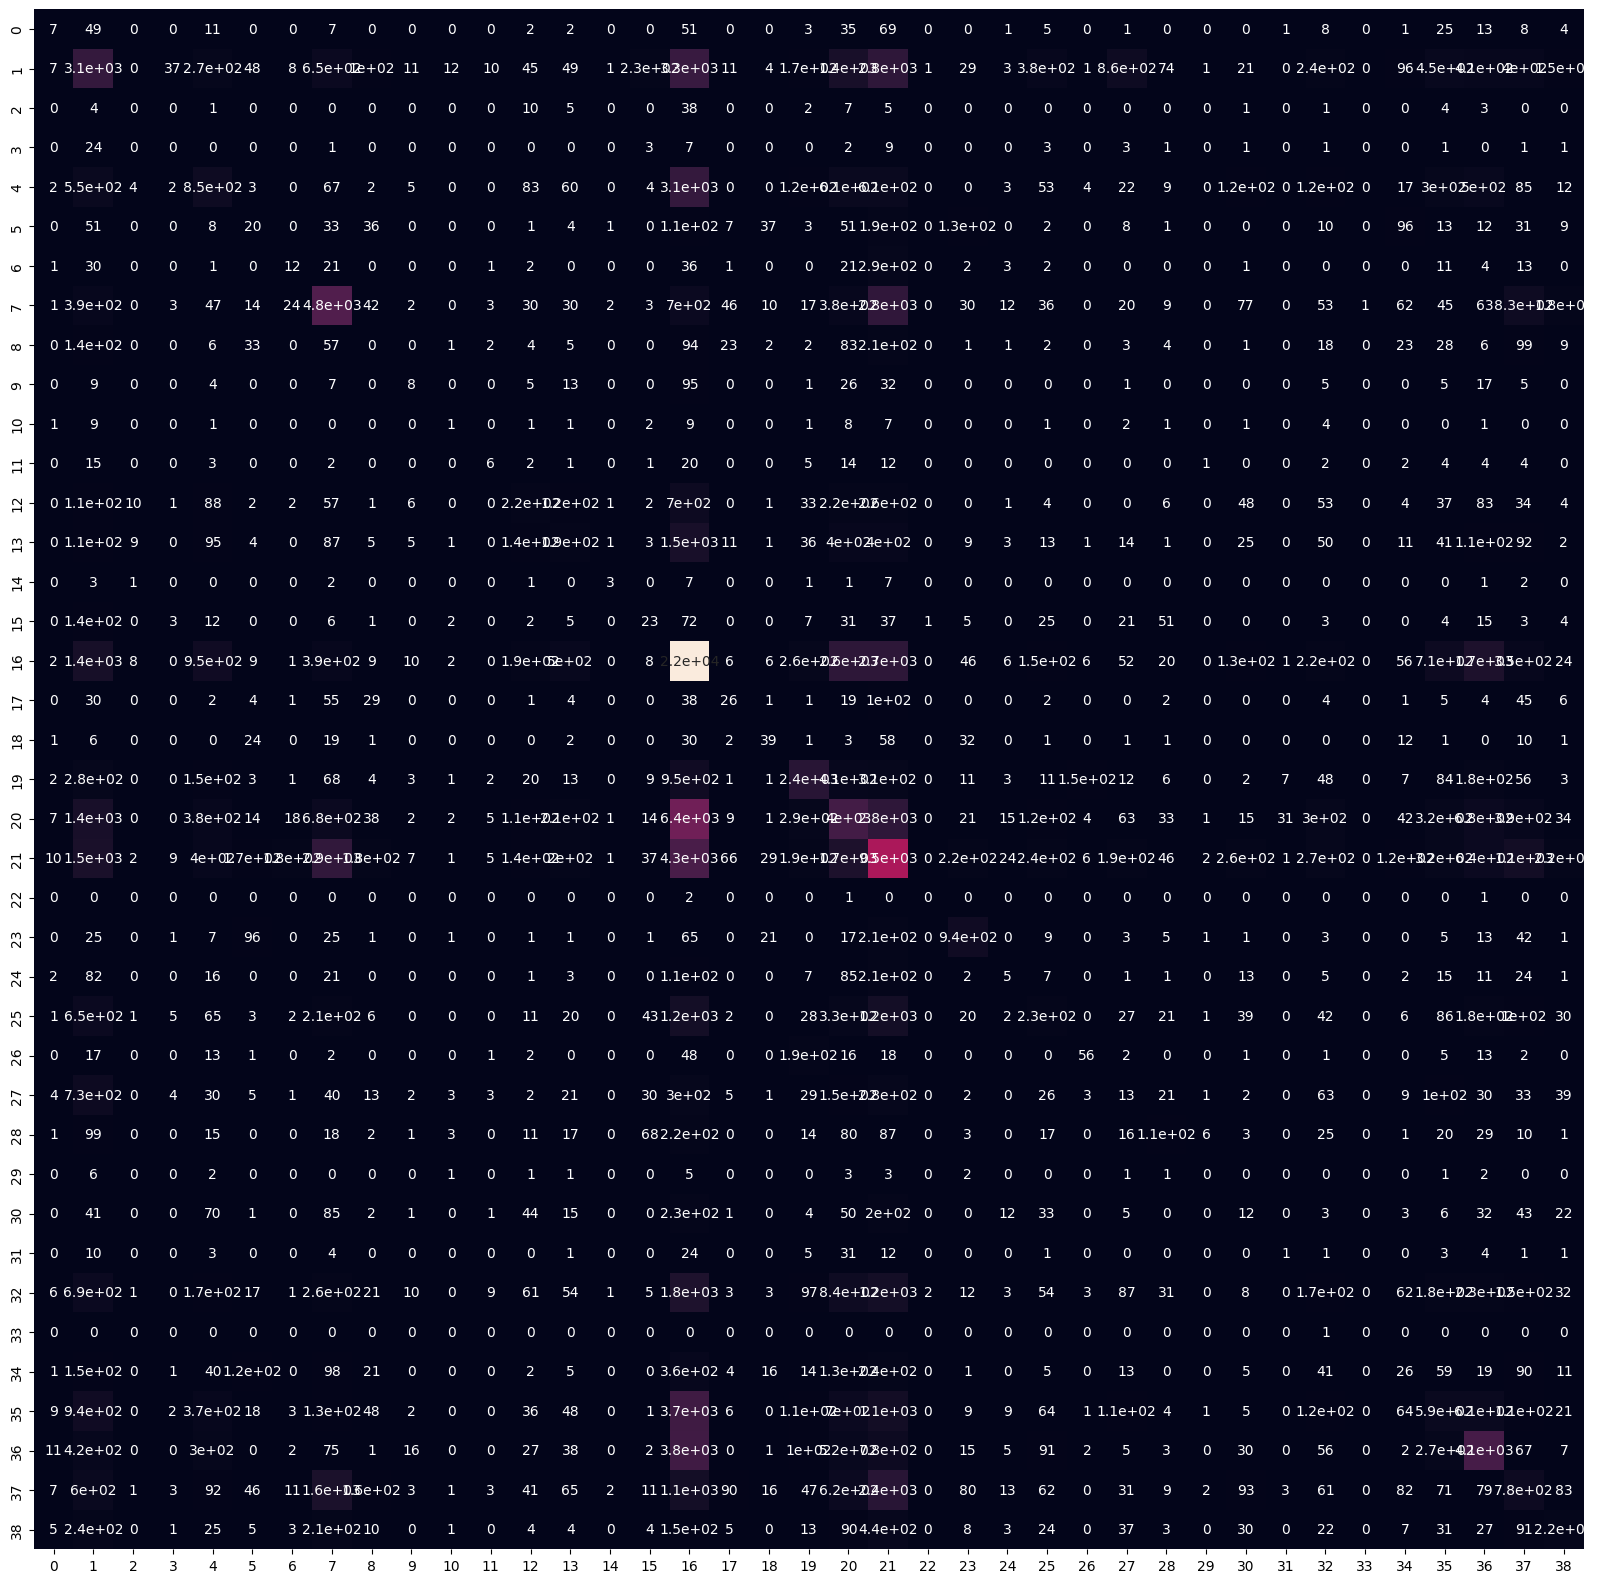

In [62]:
plt.figure(figsize=(20, 20))
sn.heatmap(confusion_matrix(y_test, pred), annot= True, cbar=False)

In [47]:
test.rename(columns={'DayofMonth': 'DayOfMonth'}, inplace = True)
test_prediction = cat_model.predict_proba(test)

In [61]:
cat_test_pred = pd.DataFrame(test_prediction, columns=["ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY", "DISORDERLY CONDUCT",
"DRIVING UNDER THE INFLUENCE", "DRUG/NARCOTIC", "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION",
"FAMILY OFFENSES", "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING", "KIDNAPPING", "LARCENY/THEFT",
"LIQUOR LAWS", "LOITERING", "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENSES", "PORNOGRAPHY/OBSCENE MAT",
"PROSTITUTION", "RECOVERED VEHICLE", "ROBBERY", "RUNAWAY", "SECONDARY CODES", "SEX OFFENSES FORCIBLE",
"SEX OFFENSES NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE", "SUSPICIOUS OCC", "TREA", "TRESPASS",
"VANDALISM", "VEHICLE THEFT", "WARRANTS", "WEAPON LAWS"])
cat_test_pred.to_csv(r'/kaggle/working/cat_test_prediction.csv', index = False)